In [1]:
import torch
from torch.utils.data import Dataset, DataLoader, Subset
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pytorch_lightning as pl
from torchmetrics import MetricCollection, AUROC, CalibrationError, SumMetric, Accuracy
import wandb
from utils_datamodel.wandb_utils import load_model, parse_runs, wandb_table_to_dataframe
from pytorch_lightning.loggers import WandbLogger
from pytorch_lightning.callbacks import ModelCheckpoint, Callback


import os
from src.base_models import RegNet, NllLoss
from src.semiSub_model import getModel
from torchmetrics import MeanSquaredError, MeanAbsoluteError
from tqdm.notebook import tqdm
from functools import partial
import torch.distributions as dist
from sklearn.model_selection import StratifiedKFold
from utils_datamodel.utils import FastFillTensorDataLoader

import arviz as az

# %load_ext tensorboard
sns.set_style("darkgrid")
if torch.cuda.is_available() and 1:
    print("Use cuda. Device: ", torch.cuda.get_device_name(torch.cuda.current_device()))
    device = torch.device('cuda', torch.cuda.current_device())
else:
    device = torch.device('cpu')
print("Device: ", device)
%load_ext autoreload
%autoreload 2
%env WANDB_BASE_URL http://141.37.176.203:8080
%env WANDB_NOTEBOOK_NAME ./semi_regression_train.ipynb

wandb_project = 'reg_semi_small_split_4dimSpace'
use_ortho = False
seed = 0

fig_width_pt = 234.8  # Get this from LaTeX using \showthe\columnwidth
inches_per_pt = 1.0/72.27               # Convert pt to inches
golden_mean = (np.sqrt(5)-1.0)/2.0         # Aesthetic ratio
fig_width = fig_width_pt*inches_per_pt  # width in inches
fig_height =fig_width*golden_mean       # height in inches
figsize = [fig_width,fig_height]
print("Figure size=", figsize)
tex_fonts = {
    # Use LaTeX to write all text
    "text.usetex": True,
    # "text.latex.preamble": r'\usepackage{amsfonts}',
    "font.family": "Nimbus Sans",
    # Use 10pt font in plots, to match 10pt font in document
    "axes.labelsize": 10,
    "font.size": 10,
    # Make the legend/label fonts a little smaller
    "legend.fontsize": 9,
    "legend.title_fontsize": 10,
    "xtick.labelsize": 10,
    "ytick.labelsize": 10,
    "figure.figsize":figsize
}
plt.rcParams.update(tex_fonts)

Use cuda. Device:  NVIDIA GeForce RTX 3080 Ti
Device:  cuda:0
env: WANDB_BASE_URL=http://141.37.176.203:8080
env: WANDB_NOTEBOOK_NAME=./semi_regression_train.ipynb
Figure size= [3.2489276324892766, 2.0079477038671003]


## data geneartion

<Axes: >

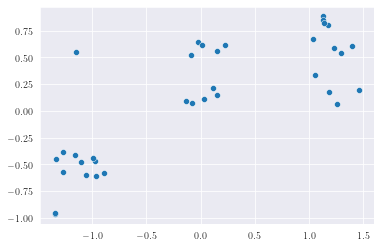

In [2]:
from torch.utils.data import TensorDataset
ds = torch.load('regression_TensorDataSet.ds')
dataset = ds['dataset']
u = torch.flatten(dataset[:][0], start_dim=1)
x = torch.flatten(dataset[:][1], start_dim=1)
data = torch.cat([u,x], dim=1)
dataset = TensorDataset(data, dataset[:][2][:,None]) # reshape y into shape bx1 for MSE loss
cuda_loader = FastFillTensorDataLoader(dataset, batch_size=len(dataset), shuffle=True,
                                       pin_memory=False)
data_mean = ds['mean']
data_std = ds['std']
dataset_test = ds['dataset_test']
u = torch.flatten(dataset_test[:][0], start_dim=1)
x = torch.flatten(dataset_test[:][1], start_dim=1)
data = torch.cat([u,x], dim=1)
dataset_test = TensorDataset(data, dataset_test[:][2][:,None])
cuda_loader_test = FastFillTensorDataLoader(dataset_test, batch_size=len(dataset_test), shuffle=False,
                                            pin_memory=False)
sns.scatterplot(x=dataset[:][0][:,0].detach().cpu().numpy(), y=dataset[:][-1].detach().cpu().numpy().squeeze())

## Train model 

In [3]:
from src.semiSub_model import SemiAdditive


class SemiRegLaplace(SemiAdditive, RegNet):
    def __init__(self, num_structure, output_dim, **kwargs):
        super(SemiRegLaplace, self).__init__(num_structure=num_structure, output_dim=output_dim, **kwargs)
        self.u_shape = (2,)
        self.x_input_feature = num_structure
    
    def forward(self, data) -> torch.Tensor:
        x = data[:,-self.x_input_feature:]
        u = data[:,:-self.x_input_feature].reshape(-1,*self.u_shape)
        eta_prime = super().forward((u, x))
        return eta_prime
        
    def training_step(self, train_batch, batch_idx) -> torch.Tensor:
        data, y = train_batch
        eta_prime = self(data)
        loss = self.loss_fn(eta_prime, y)
        self.log('train/loss', loss, on_step=True, on_epoch=True, sync_dist=True)
        return loss

    def validation_step(self, batch, batch_idx) -> dict:
        data, y = batch
        eta_prime = self(data)
        loss = self.loss_fn(eta_prime, y)
        self.log('valid/loss', loss, on_step=False, on_epoch=True, sync_dist=True)
        self.valid_metrics(eta_prime, y)
        self.log_dict(self.valid_metrics, on_step=False, on_epoch=True)
        return eta_prime.detach()

    def test_step(self, batch, batch_idx) -> dict:
        data, y = batch
        eta_prime = self(data)
        loss = self.loss_fn(eta_prime, y)
        self.log('test/loss', loss, on_step=False, on_epoch=True, sync_dist=True)
        self.test_metrics(eta_prime, y)
        self.log_dict(self.test_metrics, on_step=False, on_epoch=True)
        return eta_prime.detach()

In [4]:
from src.base_models import RegNet
from src.semiSub_model import getModel
from src.plot import exclude_project_code_dirs
from pytorch_lightning.callbacks import TQDMProgressBar

base_net_kwargs = {"dimensions": [16, 16],
                   "output_dim": 1,
                   "input_dim": 2}
# outcome_dist = torch.distributions.Normal  # outcome distributions
# loss_fn = NllLoss(outcome_dist,
#                   constrains={'loc': torch.nn.Identity()},
#                   scale=.05,
#                   reduction='mean')
loss_fn = torch.nn.MSELoss(reduction='mean')

net_kwargs = dict(lr=1e-3,
                  weight_decay=1e-5,
                  loss_fn=loss_fn,
                  num_structure=2,
                  ortho_layer_name_nn_head=None
                  )
ssr_model = SemiRegLaplace(**net_kwargs, **base_net_kwargs, seed=10).to(device=device)
print(ssr_model.structure_lin.weight)


# speed up visualization
class NoValProgressBar(TQDMProgressBar):
    def init_validation_tqdm(self):
        bar = tqdm(
            disable=True,
        )
        return bar

    def _update_n(bar, value: int) -> None:
        if not bar.disable:
            bar.n = value
            bar.update(0)  # let tqdm decide when to trigger a display refresh
bar = NoValProgressBar() 

wandb_logger = WandbLogger(project="semi_regression_laplace", log_model=False, name="model_curve", group="RegNetCurve")
# log code
wandb_logger.experiment.log_code("./", name=f"project_code_{wandb_logger.experiment.id}",
                                    exclude_fn=exclude_project_code_dirs)
ckp_dir = os.path.join(wandb_logger.experiment.dir, "checkpoints")
callbacks = [ModelCheckpoint(dirpath=ckp_dir, save_top_k=1, monitor="train/loss_epoch"), bar]

# train curve model
trainer = pl.Trainer(devices=1,
                     max_epochs=2000,
                     logger=wandb_logger,
                     callbacks=callbacks
                     )
trainer.fit(ssr_model, train_dataloaders=cuda_loader)
wandb.finish()

/home/daniel/miniconda3/envs/laplace/lib/python3.9/site-packages/pytorch_lightning/utilities/parsing.py:197: UserWarning: Attribute 'loss_fn' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss_fn'])`.
  rank_zero_warn(
/home/daniel/miniconda3/envs/laplace/lib/python3.9/site-packages/pytorch_lightning/utilities/parsing.py:197: UserWarning: Attribute 'metric_collection' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['metric_collection'])`.
  rank_zero_warn(
Global seed set to 10


SemiAdditive
RegNet
Parameter containing:
tensor([[-0.1513, -0.2019]], device='cuda:0', requires_grad=True)


wandb: Currently logged in as: ddold. Use `wandb login --relogin` to force relogin


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/daniel/miniconda3/envs/laplace/lib/python3.9/site-packages/pytorch_lightning/trainer/configuration_validator.py:71: PossibleUserWarning: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
  rank_zero_warn(
You are using a CUDA device ('NVIDIA GeForce RTX 3080 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | loss_fn       | MSELoss          | 0     
1 | valid_metrics | MetricCollection | 0     
2 | te

Epoch 1999: 100%|██████████| 1/1 [00:00<00:00, 189.65it/s, v_num=268i]

`Trainer.fit` stopped: `max_epochs=2000` reached.


Epoch 1999: 100%|██████████| 1/1 [00:00<00:00, 102.12it/s, v_num=268i]


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train/loss_epoch,█▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/loss_step,█▅▄▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
trainer/global_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
epoch,1999
train/loss_epoch,0.0025
train/loss_step,0.0025
trainer/global_step,1999


In [5]:
ssr_model = ssr_model.to(device=device)

<Axes: >

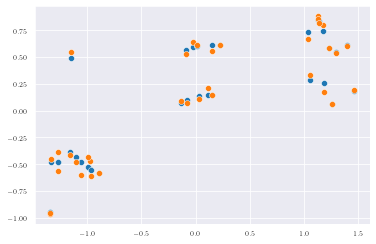

In [6]:
pred = ssr_model(dataset[:][0]).squeeze()
pred = pred.detach().cpu().numpy()
sns.scatterplot(x=dataset[:][0][:,0].detach().cpu().numpy(), y=pred)
sns.scatterplot(x=dataset[:][0][:,0].detach().cpu().numpy(), y=dataset[:][1].detach().cpu().numpy().squeeze())

## apply Laplace approximation

In [9]:
torch.set_default_device(device=device)

In [10]:
from laplace.utils import ModuleNameSubnetMask
from laplace import Laplace
subnetwork_mask = ModuleNameSubnetMask(ssr_model, module_names=['structure_lin', 'dnn.4'])
subnetwork_mask.select()
subnetwork_indices = subnetwork_mask.indices.cpu()
subnetwork_indices

# Define and fit subnetwork LA using the specified subnetwork indices
la = Laplace(ssr_model.to(device=device), 'regression',
            #  subset_of_weights='all',
            sigma_noise=0.05,
            #  hessian_structure='lowrank',
             subset_of_weights='subnetwork',
             hessian_structure='full',
             subnetwork_indices=subnetwork_indices,
)
la.fit(cuda_loader)

/home/daniel/miniconda3/envs/laplace/lib/python3.9/site-packages/backpack/extensions/backprop_extension.py:106: UserWarning: Extension saving to grad_batch does not have an extension for Module <class '__main__.SemiRegLaplace'> although the module has parameters
  warnings.warn(


tensor([-0.4681,  0.8743])

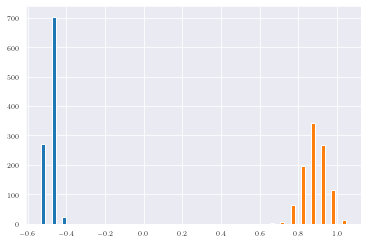

In [11]:
subnetwork_mask_struct = ModuleNameSubnetMask(ssr_model, module_names=['structure_lin'])
subnetwork_mask_struct.select()
subnetwork_mask_struct.indices
structure_samples = la.sample(1000).cpu()[:, subnetwork_mask_struct.indices.cpu()]
from matplotlib import pyplot as plt
plt.hist(structure_samples.detach().cpu().numpy(), bins=30)
structure_samples.mean(0)

In [12]:
structure_samples = la.sample(10000)[:, subnetwork_mask_struct.indices]
theta = structure_samples 
coords = {'theta_dim_0': [0,],'theta_dim_1':[0,1]}
dims = {"theta":['theta_dim_0', 'theta_dim_1']}
data = {'theta':theta.detach().cpu().numpy().reshape(1,-1,1,2)}
post_laplace_theta = az.convert_to_inference_data(data, coords=coords, dims=dims)
post_laplace_theta.to_netcdf("post_laplace_theta.nc")
post_laplace_theta

Inference data with groups:
	> posterior

In [13]:
# Load HMC results
art = wandb.Api().artifact('ddold/semi_regression_v2/data_wuwhc7kr:v0')
az_post_hmc_fullSpace = az.from_netcdf(art.file())
az_post_hmc_fullSpace

Inference data with groups:
	> posterior
	> posterior_predictive
	> sample_stats
	> prior
	> prior_predictive
	> observed_data

<ipython-input-61-22faa37f55ed>:42: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


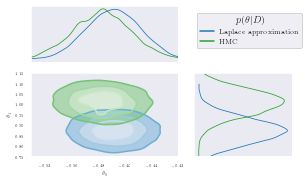

In [61]:
labeller = az.labels.MapLabeller(var_name_map={"theta": r"$\theta$", "varphi": r"$\varphi$"})
gs_kw = dict(height_ratios=[figsize[0]*0.4, figsize[0]*0.6], width_ratios=[figsize[1]*0.6, figsize[1]*0.4])
fig6, f6_axes = plt.subplots(ncols=2, nrows=2, constrained_layout=True, figsize=(figsize[0]*1.3, figsize[1]*1.3),
        gridspec_kw=gs_kw)
axes = az.plot_pair(post_laplace_theta, 
    var_names="theta", 
    labeller=labeller, 
    marginals=True, 
    kind='kde', 
    figsize=figsize,
    ax=f6_axes,
    marginal_kwargs={'color':sns.color_palette()[0]}, 
    kde_kwargs=dict(hdi_probs=[0.25, 0.5, 0.75],
                    contour_kwargs={"colors":sns.color_palette('tab20c')[:4]},
                    contourf_kwargs={"alpha":0.5, 'colors':sns.color_palette('tab20c')[:4]}))
axes = az.plot_pair(az_post_hmc_fullSpace, 
             var_names="theta", 
             labeller=labeller, 
             marginals=True, 
             figsize=figsize,
             kind='kde', 
             ax=axes, 
             marginal_kwargs={'color':sns.color_palette()[2]}, 
             kde_kwargs=dict(hdi_probs=[0.25, 0.5, 0.75], 
                             contour_kwargs={"colors":sns.color_palette('tab20c')[8:12]},
                             contourf_kwargs={"alpha":0.5, 'colors':(sns.color_palette('tab20c')[8:12])}))

import matplotlib.lines as mlines
blue_line = mlines.Line2D([], [], color=sns.color_palette()[0], label='Laplace approximation')
green_line = mlines.Line2D([], [], color=sns.color_palette()[2], label='HMC')
fig6.legend(handles=[blue_line, green_line], loc='outside upper right', bbox_to_anchor=(1., .915,), bbox_transform=fig6.transFigure, mode=None, borderaxespad=0., title=r'$p(\boldsymbol{\theta}|\mathcal{D})$')
axes[1][0].set_xlabel(r'$\theta_0$')
axes[1][0].set_ylim(0.75,1.15)
axes[1][0].set_xlim(-0.53,-0.42)
axes[1][1].set_ylim(0.75,1.15)
axes[0][0].set_xlim(-0.53,-0.42)
axes[0][0].set_xticks([])
axes[0][0].set_yticks([])
axes[1][1].set_xticks([])
axes[1][1].set_yticks([])
axes[1][0].set_ylabel(r'$\theta_1$')
plt.tight_layout()
plt.savefig("figures2/regression_posterior_toy_Laplace.pdf")

## check predictive perfromance

In [ ]:
la.predictive_samples(torch.randn(5,4), pred_type='nn', n_samples=100).shape

torch.Size([100, 5, 1])

(1, 1000, 100)
(1, 1000, 100)
(1, 1000, 100)


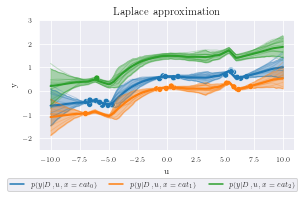

In [48]:
from src.semi_sub_utils import features


u_predictive = np.linspace(-10, 10, 100)
u_predictive_t = (features(u_predictive) - data_mean) / data_std
u_predictive_t = torch.from_numpy(u_predictive_t.astype(np.float32)).to(device=device)

meta_zero = torch.zeros_like(u_predictive_t)
post_pred_samples_00 = la.predictive_samples(torch.hstack([u_predictive_t,meta_zero]), pred_type='nn', n_samples=1000).detach().cpu().numpy()
meta_zero[:,0] = 1.
post_pred_samples_01 = la.predictive_samples(torch.hstack([u_predictive_t,meta_zero]), pred_type='nn', n_samples=1000).detach().cpu().numpy()
meta_zero[:,0] = 0.
meta_zero[:,1] = 1.
post_pred_samples_10 = la.predictive_samples(torch.hstack([u_predictive_t,meta_zero]), pred_type='nn', n_samples=1000).detach().cpu().numpy()

fig = plt.figure(figsize=np.array(figsize)*1.3)
# plot_data(exp_col)
def plot_samples(x_axis, preds, ax, color='blue'):
    preds = preds.squeeze()
    mu = preds.mean(0)
    sigma = preds.std(0)
    print(preds[None,:,:].shape)
    hdi = az.hdi(az.convert_to_dataset(preds[None,:,:], )).x.to_numpy()

    ax.plot(x_axis, mu, "-", lw=2., color=color)
    ax.plot(x_axis, hdi[:,0], "-", lw=0.75, color=color, alpha=0.5)
    ax.plot(x_axis, hdi[:,1], "-", lw=0.75, color=color, alpha=0.5)

    np.random.shuffle(preds)
    for traj in preds[:10]:
        ax.plot(x_axis, traj, "-", alpha=.25, color=color, lw=1.)

    ax.fill_between(x_axis, hdi[:,0], hdi[:,1], alpha=0.35, color=color)

plot_samples(u_predictive, post_pred_samples_00, ax=plt.gca(), color=sns.color_palette()[0])
plot_samples(u_predictive, post_pred_samples_01, ax=plt.gca(), color=sns.color_palette()[1])
plot_samples(u_predictive, post_pred_samples_10, ax=plt.gca(), color=sns.color_palette()[2])
plt.title("Laplace approximation")
plt.ylim(-2.5,3)
plt.gca().set_ylabel("y")
plt.gca().set_xlabel("u")

torch.save(dict(u_predictive = u_predictive,
post_pred_samples_10 = post_pred_samples_10,
post_pred_samples_00 = post_pred_samples_00,
post_pred_samples_01 = post_pred_samples_01,
), "laplace_posterior_predictive_samples.tensors")

# Define a mapping of categories based on combinations
category_mapping = {
    (0, 0): 'cat_0',
    (1, 0): 'cat_1',
    (0, 1): 'cat_2',
}

# Convert the last dimension of the tensor to category strings
categories = [category_mapping.get(tuple(item)) for item in dataset[:][0][:,2:].cpu().numpy()]
sns.scatterplot(x=dataset[:][0][:,0].cpu().numpy()*data_std[0]*2+data_mean[0], y=dataset[:][1][:,0].cpu().numpy(), hue=categories, legend=False)

import matplotlib.lines as mlines
blue_line = mlines.Line2D([], [], color=sns.color_palette()[0],
                          markersize=15, label=r'$p(y|D,u,x=cat_0)$')
orange_line = mlines.Line2D([], [], color=sns.color_palette()[1],
                          markersize=15, label=r'$p(y|D,u,x=cat_1)$')
green_line = mlines.Line2D([], [], color=sns.color_palette()[2],
                          markersize=15, label=r'$p(y|D,u,x=cat_2)$')
fig.legend(handles=[blue_line, orange_line, green_line], loc='outside lower center', bbox_to_anchor =(.5,-0.05), ncols=3)
# Adjust layout and show the plots
plt.tight_layout()
plt.savefig("figures2/fig1_Laplace_approx.pdf", bbox_inches='tight')

In [60]:
# compute test lppd
outcome_dist = torch.distributions.Normal  # outcome distributions
loss_fn = NllLoss(outcome_dist,
                  constrains={'loc': torch.nn.Identity()},
                  scale=.05,
                  reduction='none')
pointwise_ll = []
for data, y_test in cuda_loader_test:
    pred = la.predictive_samples(data, pred_type='nn', n_samples=2000)
    p_ll = -loss_fn(pred, y_test.squeeze())
    pointwise_ll.append(p_ll)
pointwise_ll = torch.concatenate(pointwise_ll, dim=-1).to(device=device)
lppd_test = (torch.logsumexp(pointwise_ll, dim=0) - np.log(pointwise_ll.shape[0])).mean()
lppd_test

tensor(1.0066, device='cuda:0')